## Package required

In [559]:
from warnings import filterwarnings

filterwarnings("ignore")

In [882]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.feature_selection import SelectKBest,f_classif,chi2
from sklearn.preprocessing import StandardScaler
from sklearn import tree
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [561]:
X_train=pd.read_table("ada_train.data",delim_whitespace=True,header=None)
X_valid=pd.read_table("ada_valid.data",delim_whitespace=True,header=None)
X_test=pd.read_table("ada_test.data",delim_whitespace=True,header=None)


y_train=pd.read_table("ada_train.labels",delim_whitespace=True,header=None)
y_valid=pd.read_table("ada_valid.labels",delim_whitespace=True,header=None)


Column_train={"X"+str(i):X_train.iloc[:,i-1] for i in range(1,X_train.shape[1]+1)}
Column_valid={"X"+str(i):X_valid.iloc[:,i-1] for i in range(1,X_valid.shape[1]+1)}
Column_test={"X"+str(i):X_test.iloc[:,i-1] for i in range(1,X_test.shape[1]+1)}


In [562]:
ada_train_data=pd.DataFrame(Column_train)
ada_valid_data=pd.DataFrame(Column_valid)
ada_test_data=pd.DataFrame(Column_test)

ada_train_label=pd.DataFrame({"target":y_train.iloc[:,0]})
ada_valid_label=pd.DataFrame({"target":y_valid.iloc[:,0]})

In [563]:
ada_train_data.shape,ada_valid_data.shape,ada_test_data.shape

((4147, 48), (415, 48), (41471, 48))

In [564]:
ada_train_label.shape,ada_valid_label.shape

((4147, 1), (415, 1))

In [565]:
### Check for NaN

ada_train_data.isna().any().sum(),ada_valid_data.isna().any().sum(),ada_test_data.isna().any().sum()

(0, 0, 0)

There are no NaN values in our data

In [566]:
### Data types

numerical_cols=ada_train_data.columns[ada_train_data.nunique()>2]
categorical_cols=ada_train_data.columns[ada_train_data.nunique()<=2]

In [567]:
### Get descriptive statistics from numerical data

ada_train_data[numerical_cols].describe()

,X4,X10,X15,X25,X32,X40
count,4147.000000,4147.000000,4147.000000,4147.000000,4147.000000,4147.000000
mean,126.408006,20.033036,631.886665,429.348686,10.964070,411.804196
std,69.754074,91.933304,161.410107,146.029831,76.318757,119.999993
min,13.000000,0.000000,62.000000,189.000000,0.000000,10.000000
25%,78.500000,0.000000,562.000000,311.000000,0.000000,404.000000
50%,119.000000,0.000000,624.000000,411.000000,0.000000,404.000000
75%,160.000000,0.000000,812.000000,522.000000,0.000000,454.000000
max,995.000000,648.000000,999.000000,999.000000,999.000000,999.000000


<AxesSubplot: >

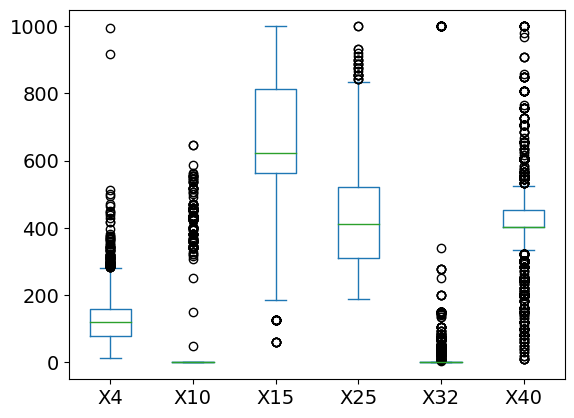

In [568]:
ada_train_data[numerical_cols].plot(kind="box")

Evidently we are facing 

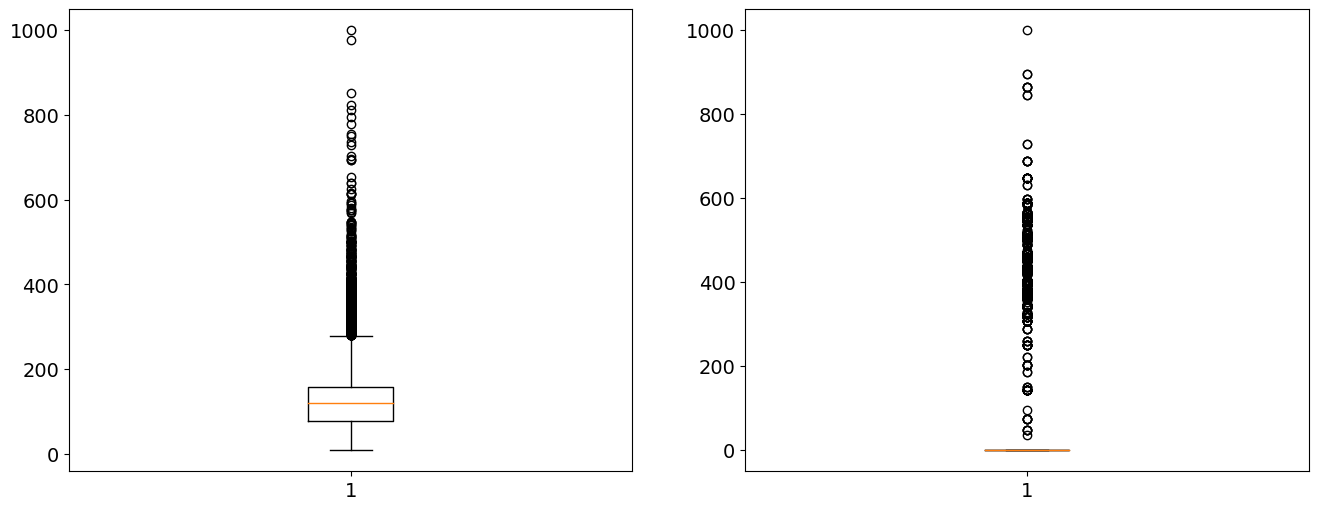

In [569]:
fig,axs=plt.subplots(ncols=2,figsize=(16,6))

axs[0].boxplot(ada_test_data[numerical_cols[0]])
axs[1].boxplot(ada_test_data[numerical_cols[1]])
plt.show()

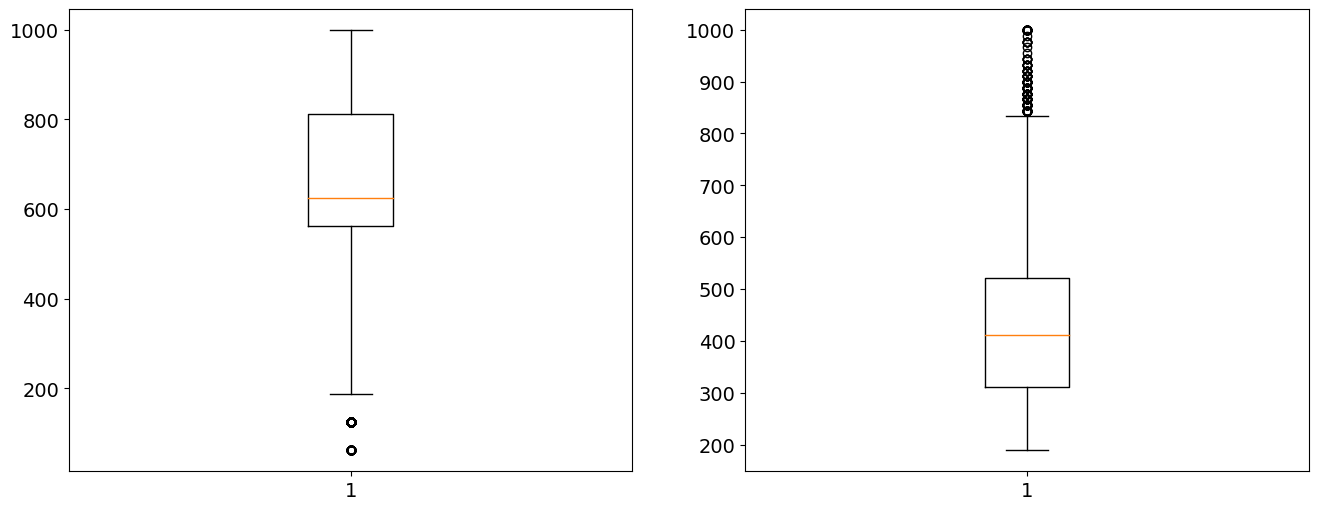

In [570]:
fig,axs=plt.subplots(ncols=2,figsize=(16,6))

axs[0].boxplot(ada_test_data[numerical_cols[2]])
axs[1].boxplot(ada_test_data[numerical_cols[3]])
plt.show()

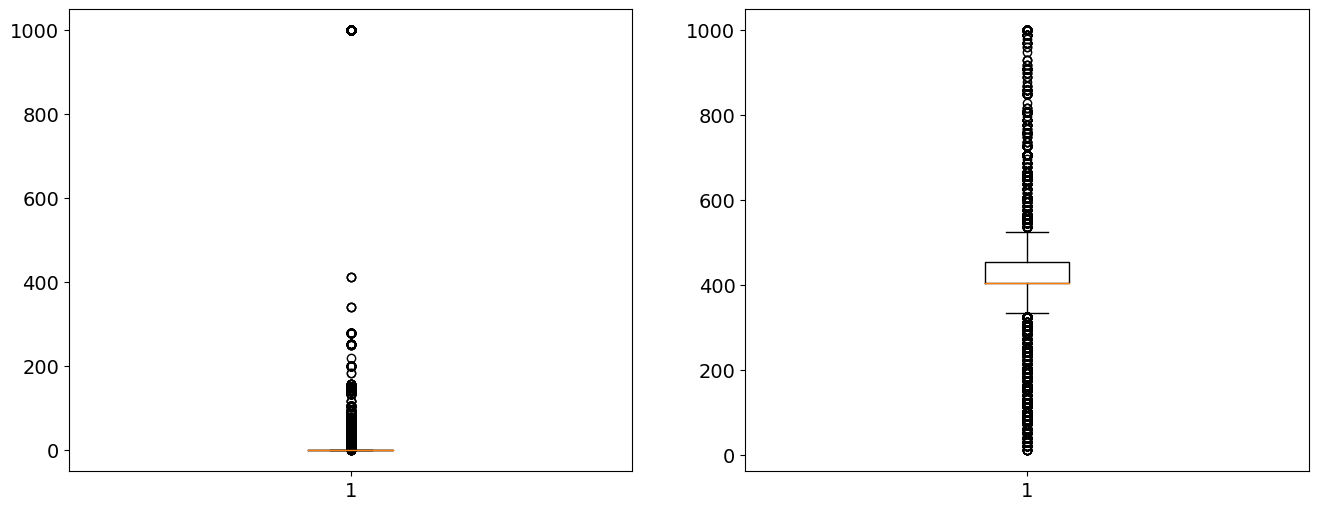

In [571]:
fig,axs=plt.subplots(ncols=2,figsize=(16,6))

axs[0].boxplot(ada_test_data[numerical_cols[4]])
axs[1].boxplot(ada_test_data[numerical_cols[5]])
plt.show()

### Outlier handling

According to the expert of data, outliers is the bigest problem that can introduce biais in analysis and hide generally tendancy most of time especially when data size is small.

There many scenarios that can worthy and very bad but there not pre-defined strategies to get directly the best strategies to handle outliers. Even if, we have this problem; according to problematic some strategies will be more useful than others.

- Filtered test data set to avoid outliers
- 

In [572]:
ada_train_data.nunique().max(),ada_train_data.nunique().min()

(330, 1)

In [573]:
ada_train_data.X21.unique(),ada_valid_data.X21.unique(),ada_test_data.X21.unique()

(array([0]), array([0]), array([0]))

In [574]:
#The column contains just a unique value then it's not useful for discrimination

ada_train_data=ada_train_data.drop(columns=['X21'])
ada_valid_data=ada_valid_data.drop(columns=['X21'])
ada_test_data=ada_test_data.drop(columns=['X21'])

In [575]:
def get_percentage_of_outlier(df):

    numerical_cols=df.columns[df.nunique()>2]
    
    n=df.shape[0]

    outlier_size={}
 
    for col in numerical_cols:

        q1=df[col].quantile(0.25)
        q3=df[col].quantile(0.75)
        IQR=q3-q1

        outliers_shape=df[(df[col]<q1-1.5*IQR)].shape[0] + df[(df[col]>q3+1.5*IQR)].shape[0]

        outlier_size[col]=outliers_shape

    return outlier_size

In [576]:
get_percentage_of_outlier(ada_train_data)

{'X4': 98, 'X10': 193, 'X15': 25, 'X25': 24, 'X32': 336, 'X40': 1108}

### Modelisation

In [577]:
Classifiers=[KNeighborsClassifier,
             LogisticRegression,
             DecisionTreeClassifier,
             GaussianNB,
             LinearDiscriminantAnalysis]

In [578]:
ada_train_data.shape,ada_train_label.shape

((4147, 47), (4147, 1))

#### Before outlier handling

In [579]:
### Data Normalisation

def normalize_num_cols(df):

    df_standard=df.copy()

    standardizing=StandardScaler()
    
    numerical_cols=df.columns[df.nunique()>2]

    standar_col_num=standardizing.fit_transform(df[numerical_cols])

    df_standard[numerical_cols]=standar_col_num

    return df_standard

In [580]:
def get_accuray(train_set,train_label,valid_set,valid_label,cv=50):

    col=["Name","Accuracy_mean","BER_mean","ROC_mean","Accuracy_std","BER_std","ROC_std"]
    df=pd.DataFrame(columns=col)
    for classifier in Classifiers:
        Name=classifier.__name__
        model=classifier().fit(train_set,train_label)
        y_pred=model.predict(valid_set)
        acc=np.mean(cross_val_score(model,train_set,train_label,scoring="accuracy",cv=cv))
        BER=np.mean(cross_val_score(model,train_set,train_label,scoring="balanced_accuracy",cv=cv))
        ROC=np.mean(cross_val_score(model,train_set,train_label,scoring="roc_auc",cv=cv))

        acc_std=np.std(cross_val_score(model,train_set,train_label,scoring="accuracy",cv=cv))
        BER_std=np.std(cross_val_score(model,train_set,train_label,scoring="balanced_accuracy",cv=cv))
        ROC_std=np.std(cross_val_score(model,train_set,train_label,scoring="roc_auc",cv=cv))
        #acc=metrics.accuracy_score(valid_label,y_pred)
        #BER=metrics.balanced_accuracy_score(valid_label,y_pred)
        #ROC=metrics.roc_auc_score(valid_label,y_pred)

        df1=pd.DataFrame([[Name,acc,BER,ROC,acc_std,BER_std,ROC_std]],columns=col)
        df=df.append(df1)

    return df

In [581]:
accuracy_df=get_accuray(ada_train_data,ada_train_label,ada_valid_data,ada_valid_label)

In [582]:
### For normalized data

ada_train_data_standard=normalize_num_cols(ada_train_data)
ada_valid_data_standard=normalize_num_cols(ada_valid_data)

accuracy_df_stand=get_accuray(ada_train_data_standard,ada_train_label,ada_valid_data_standard,ada_valid_label)

#### After handling

In [583]:
from sklearn.impute import KNNImputer

def replace_outlier(x,min_whisker,max_whisker):

    if x<min_whisker or x>max_whisker:

        x=np.NaN
    
    return x


def fill_outlier(df_ada,method):

    numerical_cols=df_ada.columns[df_ada.nunique()>2]
 
    for col in numerical_cols:

        q1=df_ada[col].quantile(0.25)
        
        q3=df_ada[col].quantile(0.75)

        IQR=q3-q1

        min_whisker=q1-1.5*IQR
        max_whisker=q3+1.5*IQR

        df_ada[col]=df_ada[col].apply(lambda x: replace_outlier(x,min_whisker,max_whisker))

    if method=="mean":
            
        df_ada=df_ada.fillna(df_ada.mean())
        
    if method=="knn":
            
        imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

        df_ada[numerical_cols]=imputer.fit_transform(df_ada[numerical_cols])
    
    return df_ada

In [584]:
ada_train_data=fill_outlier(ada_train_data,method="knn")
ada_valid_data=fill_outlier(ada_valid_data,method="knn")

accuracy_df_outlier_trim=get_accuray(ada_train_data,ada_train_label,ada_valid_data,ada_valid_label)

In [585]:
ada_train_data_standard=normalize_num_cols(ada_train_data)
ada_valid_data_standard=normalize_num_cols(ada_valid_data)

accuracy_df_outlier_trim_stand=get_accuray(ada_train_data_standard,ada_train_label,ada_valid_data_standard,ada_valid_label)

In [586]:
accuracy_df["data"]="raw"
accuracy_df_stand["data"]="raw_standard"
accuracy_df_outlier_trim["data"]="outlier_trimmed by mean"
accuracy_df_outlier_trim_stand["data"]="outlier_trimmed by mean and standard"

accuracies=[accuracy_df,accuracy_df_stand,accuracy_df_outlier_trim,accuracy_df_outlier_trim_stand]

accuracies_df=pd.concat(accuracies)

In [587]:
accuracies_df.sort_values(by=["Accuracy_mean","BER_mean","ROC_mean"],ascending=False)

,Name,Accuracy_mean,BER_mean,ROC_mean,Accuracy_std,BER_std,ROC_std,data
0,LogisticRegression,0.848816,0.769276,0.907785,0.035495,0.058109,0.037259,raw_standard
0,LinearDiscriminantAnalysis,0.843744,0.770718,0.896773,0.038859,0.059454,0.038917,raw
0,LinearDiscriminantAnalysis,0.843744,0.770718,0.896773,0.038859,0.059454,0.038917,raw_standard
0,KNeighborsClassifier,0.835069,0.770662,0.865512,0.034882,0.049328,0.038802,raw_standard
0,LinearDiscriminantAnalysis,0.835066,0.758727,0.882846,0.039611,0.054877,0.041406,outlier_trimmed by mean
0,LinearDiscriminantAnalysis,0.835066,0.758727,0.882846,0.039611,0.054877,0.041406,outlier_trimmed by mean and standard
0,LogisticRegression,0.833864,0.746569,0.886386,0.038389,0.054891,0.039575,outlier_trimmed by mean and standard
0,LogisticRegression,0.833385,0.749486,0.882162,0.038212,0.057221,0.043802,raw
0,LogisticRegression,0.829997,0.740363,0.874823,0.034445,0.052611,0.042350,outlier_trimmed by mean
0,KNeighborsClassifier,0.815783,0.749339,0.843639,0.041793,0.052984,0.049053,outlier_trimmed by mean and standard


We find that the best model is build with standardized row data without outlier trimmed

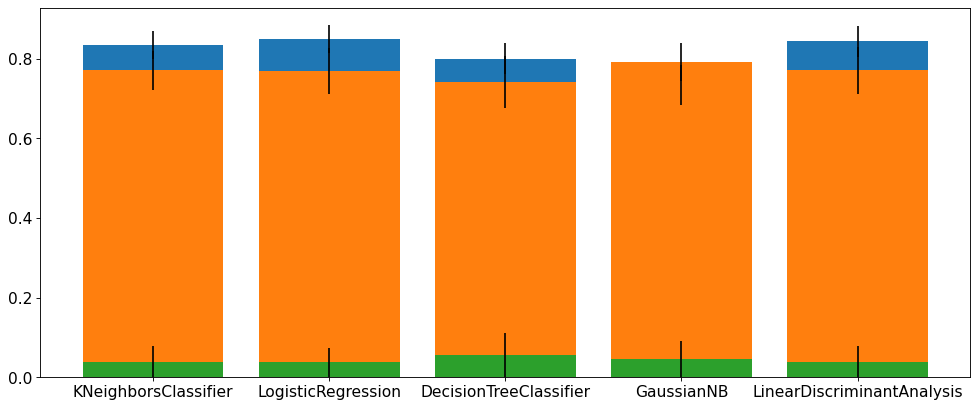

In [588]:
error_df=accuracies_df[accuracies_df["data"]=="raw_standard"][["Name","Accuracy_mean",\
    "BER_mean","ROC_mean","Accuracy_std","BER_std","ROC_std"]]
    #.plot(kind="bar",x="Name",yerr=,figsize=(16,6))

from matplotlib.pyplot import figure
figure(figsize=(15, 6), dpi=80)
plt.bar(error_df.Name,error_df["Accuracy_mean"],yerr=error_df.Accuracy_std)
plt.bar(error_df.Name,error_df["BER_mean"],yerr=error_df.BER_std)
plt.bar(error_df.Name,error_df["ROC_std"],yerr=error_df.ROC_std)
plt.show()

In [589]:
error_df

,Name,Accuracy_mean,BER_mean,ROC_mean,Accuracy_std,BER_std,ROC_std
0,KNeighborsClassifier,0.835069,0.770662,0.865512,0.034882,0.049328,0.038802
0,LogisticRegression,0.848816,0.769276,0.907785,0.035495,0.058109,0.037259
0,DecisionTreeClassifier,0.799835,0.741151,0.738935,0.038589,0.064912,0.055866
0,GaussianNB,0.734508,0.791993,0.874911,0.049496,0.046691,0.045471
0,LinearDiscriminantAnalysis,0.843744,0.770718,0.896773,0.038859,0.059454,0.038917


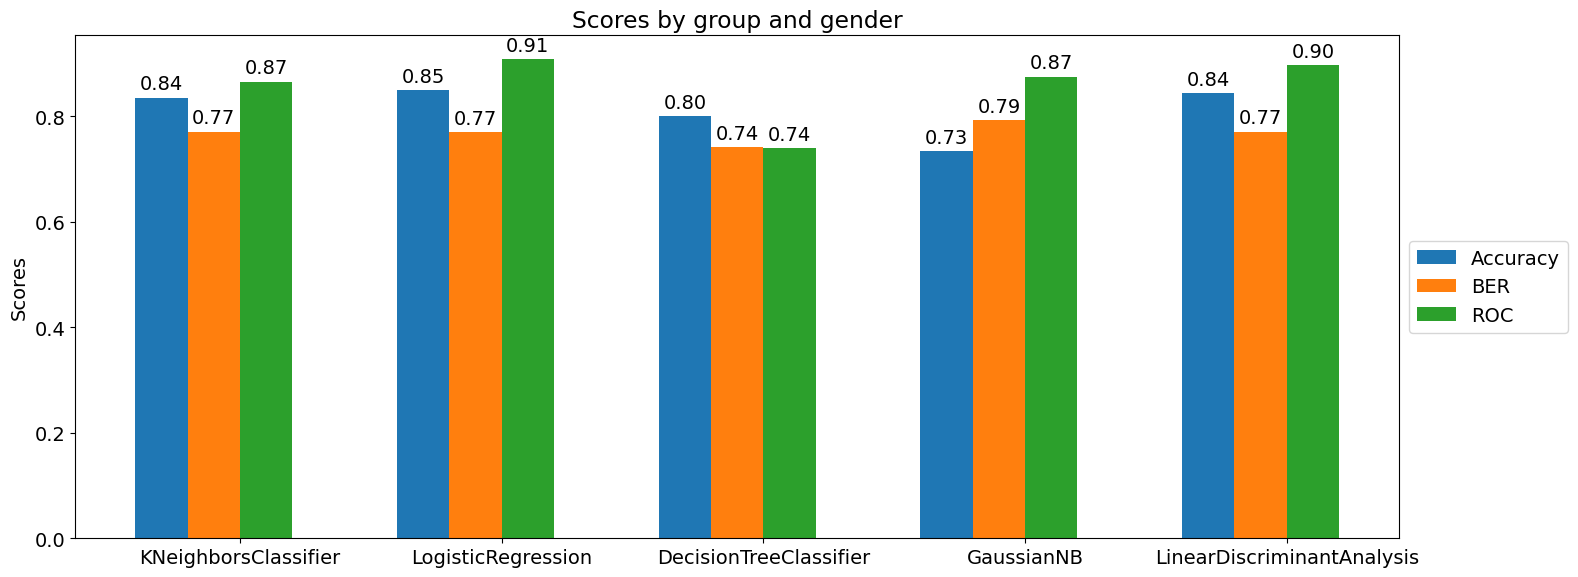

In [590]:
ind = np.arange(error_df["Accuracy_mean"].shape[0])  # the x locations for the groups
width = 0.20  # the width of the bars

fig, ax = plt.subplots(figsize=(16,6))
rects1 = ax.bar(ind - 1.5*width, error_df["Accuracy_mean"], width, #yerr=error_df["Accuracy_std"],
                label='Accuracy')
rects2 = ax.bar(ind -0.5*width, error_df["BER_mean"], width, #yerr=error_df["BER_std"],
                label='BER')

rects3 = ax.bar(ind +0.5*width, error_df["ROC_mean"], width, #yerr=error_df["ROC_std"],
                label='ROC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind)
ax.set_xticklabels(error_df["Name"])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}
    i=0
    for rect in rects:

        height = rect.get_height()

        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')
        i+=1

autolabel(rects1, "center")
autolabel(rects2, "center")
autolabel(rects3, "center")

fig.tight_layout()

plt.show()

In [591]:
error_df.Name

0          KNeighborsClassifier
0            LogisticRegression
0        DecisionTreeClassifier
0                    GaussianNB
0    LinearDiscriminantAnalysis
Name: Name, dtype: object

In [592]:
error_df["Name"]=error_df["Name"].replace("KNeighborsClassifier","KNN")
error_df["Name"]=error_df["Name"].replace("LogisticRegression","LR")
error_df["Name"]=error_df["Name"].replace("DecisionTreeClassifier","DT")
error_df["Name"]=error_df["Name"].replace("GaussianNB","Bayes")
error_df["Name"]=error_df["Name"].replace("LinearDiscriminantAnalysis","LDA")

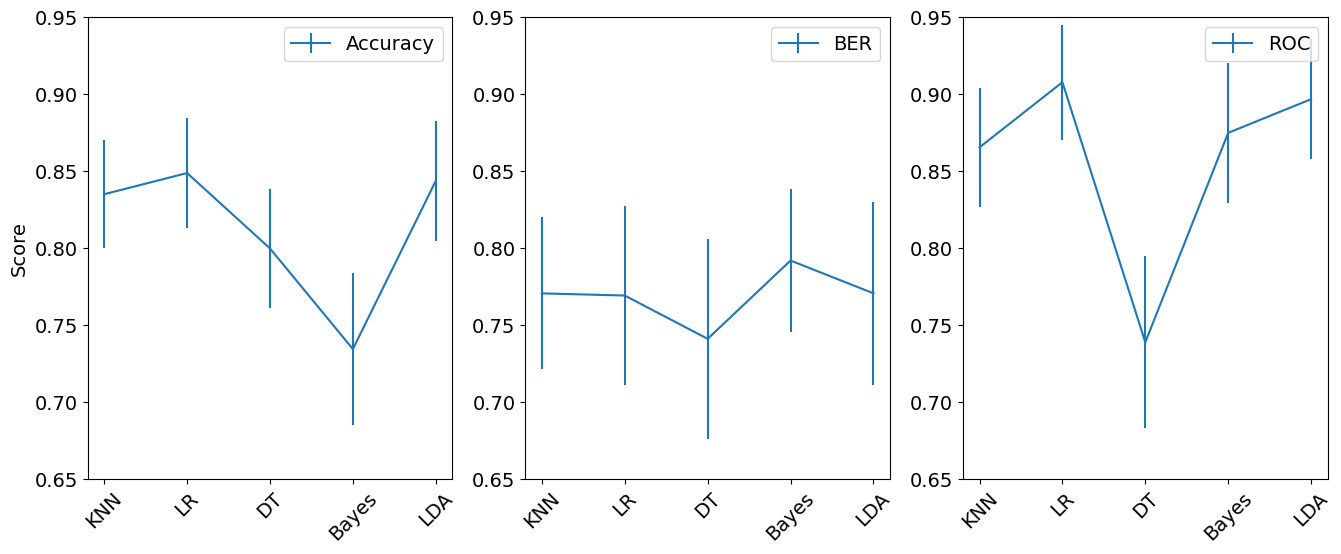

In [593]:

plt.rcParams.update({"font.size":14})
fig,axs=plt.subplots(ncols=3,figsize=(16,6))

axs[0].errorbar(error_df["Name"],error_df["Accuracy_mean"],error_df["Accuracy_std"],label="Accuracy")
axs[1].errorbar(error_df["Name"],error_df["BER_mean"],error_df["BER_std"],label="BER")
axs[2].errorbar(error_df["Name"],error_df["ROC_mean"],error_df["ROC_std"],label="ROC")

axs[0].set_ylabel("Score")

axs[0].set_ylim(0.65,0.95)
axs[1].set_ylim(0.65,0.95)
axs[2].set_ylim(0.65,0.95)

axs[0].legend()
axs[1].legend()
axs[2].legend()

axs[0].set_xticklabels(error_df["Name"],rotation=45)
axs[1].set_xticklabels(error_df["Name"],rotation=45)
axs[2].set_xticklabels(error_df["Name"],rotation=45)


plt.show()

### Feature selection

In [594]:
import time

def attribute_impact(models,X,y,n_attributes_in_range):
    
        scores_means={}
        scores_stds={}
        times={}
        
        
        for name,model in zip(models.keys(),models.values()):
            
            #train_scores,test_scores=initiate_dict(models)

            #train_scores[name]=[]
            
            check_mean={"Accuracy_mean":[],"BER_mean":[],"ROC_mean":[]}
            check_std={"Accuracy_std":[],"BER_std":[],"ROC_std":[]}
            time_dict={}

            for num_attributes in n_attributes_in_range:

                #Intialisation de la méthode de selection

                selector=SelectKBest(score_func=f_classif, k=num_attributes)

                # Entrainnement de la méthode
                selector_fitted=selector.fit(X,y)

                # Récuperation des variables sélectionnées
                columns=X.columns[selector.get_support()]

                #test_scores[name]=check
                
                start_time=time.time()

                score_accuracy=cross_val_score(model,X[columns],y,cv=30,scoring='accuracy',n_jobs=-1)
                score_ber=cross_val_score(model,X[columns],y,cv=30,scoring='balanced_accuracy',n_jobs=-1)
                score_roc=cross_val_score(model,X[columns],y,cv=30,scoring='roc_auc',n_jobs=-1)
                
                end_time=time.time()

                time_dict[num_attributes]=end_time-start_time

                #Testing score
                #Accuracy
                check_mean["Accuracy_mean"].append(np.mean(score_accuracy))
                check_std["Accuracy_std"].append(np.std(score_accuracy))

                #Presicion
                check_mean["BER_mean"].append(np.mean(score_ber))
                check_std["BER_std"].append(np.std(score_ber))


                #Recall
                check_mean["ROC_mean"].append(np.mean(score_roc))
                check_std["ROC_std"].append(np.std(score_roc))

            scores_means[name]=check_mean
            scores_stds[name]=check_std
            times[name]=time_dict
                
        return scores_means,scores_stds,times

In [595]:
ada_train_label.head()

,target
0,-1
1,-1
2,-1
3,1
4,-1


In [596]:
models={"bayes":GaussianNB(),"LR":LogisticRegression(),"LDA":LinearDiscriminantAnalysis()\
    ,"DT":DecisionTreeClassifier(),"KNN":KNeighborsClassifier()}
n_attributes_in_range=range(1,len(ada_train_data.columns)+1)
scores_means_attr,scores_std_attr,times=attribute_impact(models,ada_train_data,ada_train_label.target,n_attributes_in_range=n_attributes_in_range)

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bmarid/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

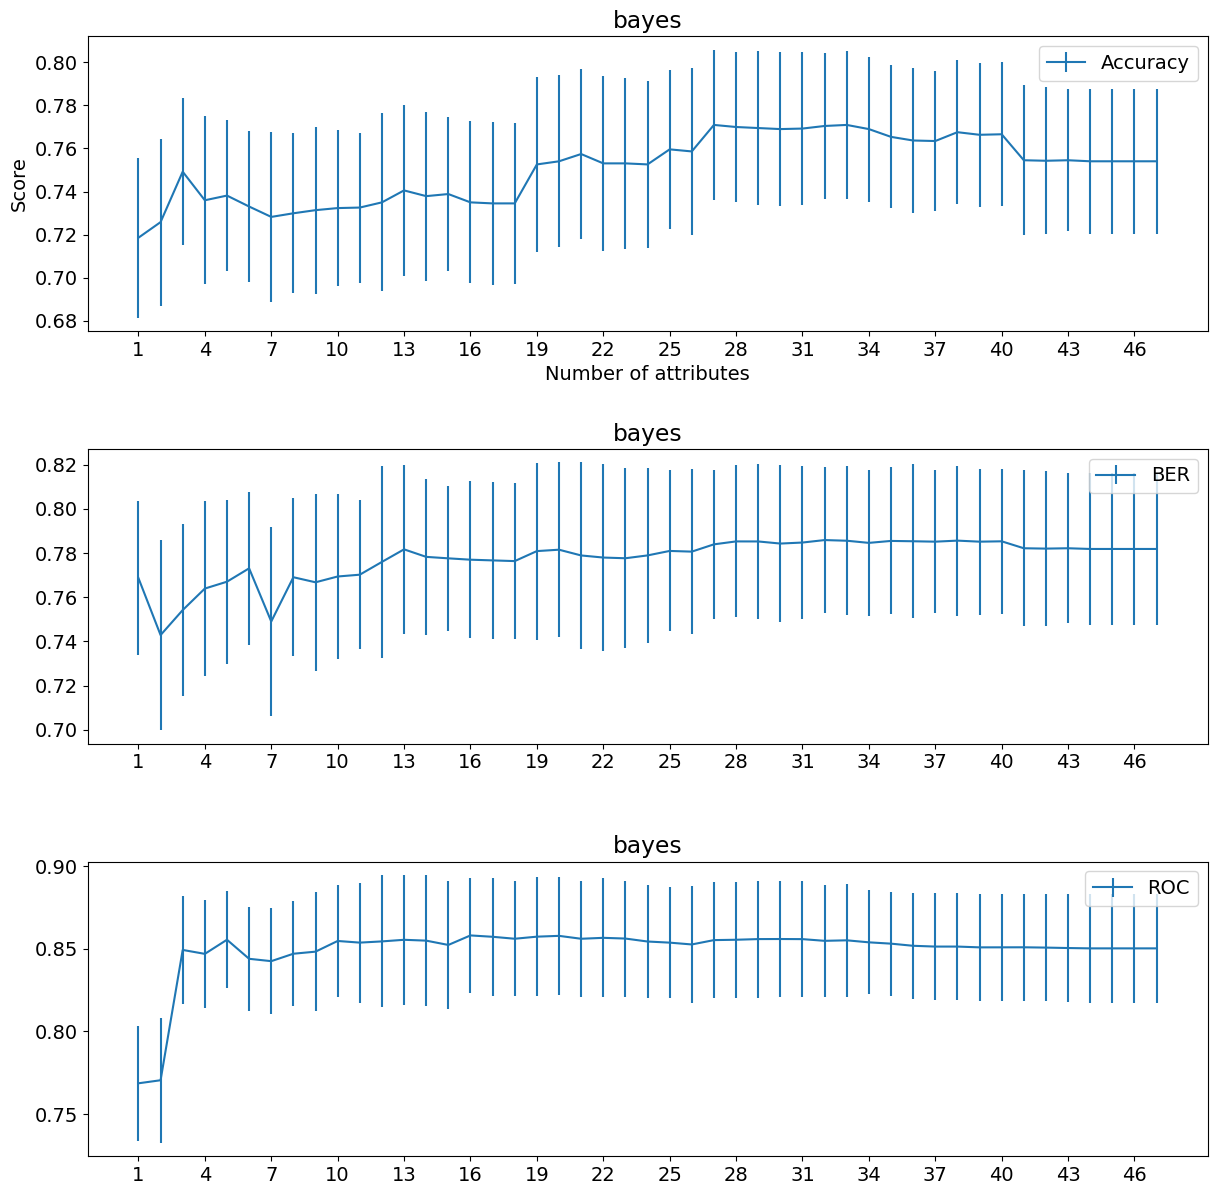

In [597]:
plt.rcParams.update({'font.size':14})

fig,axes=plt.subplots(nrows=3,figsize=(14,14))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

axes[0].errorbar(n_attributes_in_range,scores_means_attr["bayes"]["Accuracy_mean"],scores_std_attr["bayes"]["Accuracy_std"],label="Accuracy")
axes[1].errorbar(n_attributes_in_range,scores_means_attr["bayes"]["BER_mean"],scores_std_attr["bayes"]["BER_std"],label="BER")
axes[2].errorbar(n_attributes_in_range,scores_means_attr["bayes"]["ROC_mean"],scores_std_attr["bayes"]["ROC_std"],label="ROC")

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[0].set_xlabel("Number of attributes")
axes[0].set_ylabel("Score")
axes[0].set_title("bayes")
axes[1].set_title("bayes")
axes[2].set_title("bayes")
axes[0].set_xticks(np.arange(min(n_attributes_in_range), max(n_attributes_in_range)+1, 3.0))
axes[1].set_xticks(np.arange(min(n_attributes_in_range), max(n_attributes_in_range)+1, 3.0))
axes[2].set_xticks(np.arange(min(n_attributes_in_range), max(n_attributes_in_range)+1, 3.0))

plt.show()

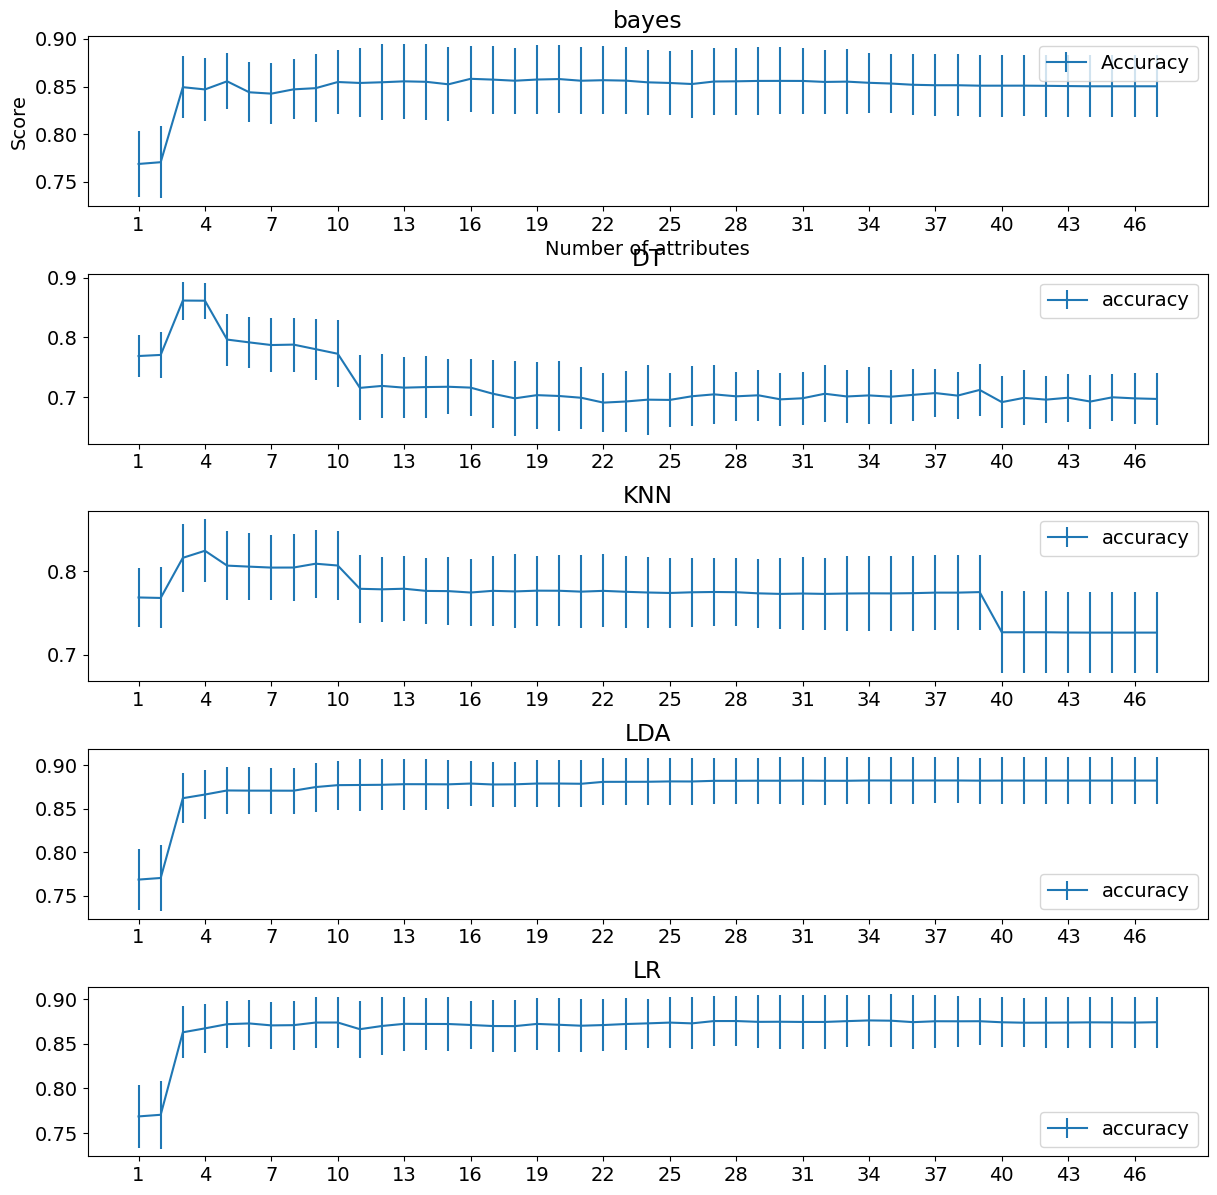

In [598]:
plt.rcParams.update({'font.size':14})

fig,axes=plt.subplots(nrows=5,figsize=(14,14))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

axes[0].errorbar(n_attributes_in_range,scores_means_attr["bayes"]["ROC_mean"],scores_std_attr["bayes"]["ROC_std"],label="Accuracy")
axes[1].errorbar(n_attributes_in_range,scores_means_attr["DT"]["ROC_mean"],scores_std_attr["DT"]["ROC_std"],label="accuracy")
axes[2].errorbar(n_attributes_in_range,scores_means_attr["KNN"]["ROC_mean"],scores_std_attr["KNN"]["ROC_std"],label="accuracy")
axes[3].errorbar(n_attributes_in_range,scores_means_attr["LDA"]["ROC_mean"],scores_std_attr["LDA"]["ROC_std"],label="accuracy")
axes[4].errorbar(n_attributes_in_range,scores_means_attr["LR"]["ROC_mean"],scores_std_attr["LR"]["ROC_std"],label="accuracy")


axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
axes[4].legend()
axes[0].set_xlabel("Number of attributes")
axes[0].set_ylabel("Score")
axes[0].set_title("bayes")
axes[1].set_title("DT")
axes[2].set_title("KNN")
axes[3].set_title("LDA")
axes[4].set_title("LR")
axes[0].set_xticks(np.arange(min(n_attributes_in_range), max(n_attributes_in_range)+1, 3.0))
axes[1].set_xticks(np.arange(min(n_attributes_in_range), max(n_attributes_in_range)+1, 3.0))
axes[2].set_xticks(np.arange(min(n_attributes_in_range), max(n_attributes_in_range)+1, 3.0))
axes[3].set_xticks(np.arange(min(n_attributes_in_range), max(n_attributes_in_range)+1, 3.0))
axes[4].set_xticks(np.arange(min(n_attributes_in_range), max(n_attributes_in_range)+1, 3.0))


plt.show()

#### Number of attributes

Acc-----------bayes:8, DT:4,KNN:5, LDA:10,LR:12 \
BER-----------bayes:28, DT:4,KNN:3, LDA:10,LR:12\
ROC-----------bayes:5, DT:4,KNN:4, LDA:10,LR:5

### Optimisation

In [599]:
from grid_search_useful_tools import plot_grid_search,table_grid_search

### Get function from other files

In [1061]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [1060]:
import lib_helper
from lib_helper import to_fix
to_fix(5.2345)

5.23

In [849]:
# def to_fix(numObj, n = 2):
#     return float(f"{numObj:.{n}f}")

In [601]:
def get_mse(func):
    predict = func # get prediction from special func, for example get_lr/get_lda
    mse = mean_squared_error(y_valid, predict)
    mse = to_fix(mse)
    return mse

In [602]:
def get_accuracy_fix(func):
    predict = func # get prediction from special func, for example get_lr/get_lda
    acc = accuracy_score(y_valid, predict)
    acc = to_fix(acc)
    return acc

In [603]:
# scaling
def scaling_std(X_train, X_valid):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_valid = scaler.transform(X_valid)
    return X_train, X_valid

X_train, X_valid = scaling_std(X_train, X_valid)

### KNN

In [805]:
def get_knn_model(X_train, y_train, n):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    return knn

In [808]:
def get_knn_predicts(X_train, X_valid, y_train, n):
    knn = get_knn_model(X_train, y_train, n)
    predict_knn = knn.predict(X_valid)
    return predict_knn

In [809]:
# take a look for n = 3
predicts_knn = get_knn_predicts(X_train, X_valid, y_train, 3)
accuracy_score_knn = to_fix(get_accuracy_fix(predicts_knn))
print(accuracy_score_knn)

0.82


### Find the best k

In [606]:
def find_best_k(X_train, X_valid, y_train, y_valid):
    training_accuracy=[]
    valid_accuracy=[]

    neighbors=range(1,15)

    for number_of_neighbors in neighbors:
        knn = KNeighborsClassifier(n_neighbors=number_of_neighbors)
        knn.fit(X_train,y_train)
        
        training_accuracy.append(knn.score(X_train,y_train) )
        
        new_acc = knn.score(X_valid,y_valid)
        valid_accuracy.append(new_acc)
        
    best_k = neighbors[valid_accuracy.index(max(valid_accuracy))]
    return training_accuracy, valid_accuracy, best_k

In [607]:
def plot_k(neighbors, valid_accuracy):
    # plt.plot(neighbors, training_accuracy, label='training acc')
    plt.plot(neighbors, valid_accuracy, label='valid accuracy')
    plt.ylabel("Accuracy")
    plt.xlabel("Number of neighbors")
    plt.legend()

best k = 5
accuracy = 0.84


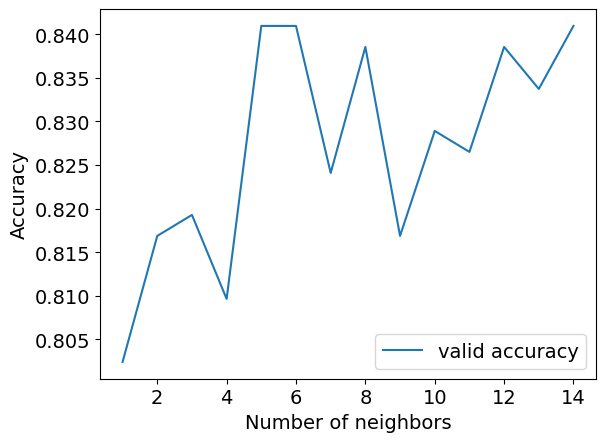

In [608]:
def knn(X_train, X_valid, y_train, best_k):
    training_accuracy, valid_accuracy, best_k = find_best_k(X_train, X_valid, y_train, y_valid)
    print("best k =",best_k)
    accuracy_score_knn = to_fix(get_accuracy_fix(get_knn_predicts(X_train, X_valid, y_train, best_k)))
    print("knn accuracy =", accuracy_score_knn)
    plot_k(neighbors, valid_accuracy)
    
knn(X_train, X_valid, y_train, best_k)

In [609]:
# accuracy_score_knn = to_fix(get_accuracy_fix(get_knn_predicts(X_train, X_valid, y_train, best_k)))
# print(accuracy_score_knn)

In [724]:
# Evaluate Model
def get_cm(y_valid, predict):
    cm = confusion_matrix(y_valid, predict)
    print(cm)
    print(classification_report(y_valid, predict)) 
    return cm

In [611]:
get_cm(y_valid, predict_knn)

[[280  32]
 [ 34  69]]
              precision    recall  f1-score   support

          -1       0.89      0.90      0.89       312
           1       0.68      0.67      0.68       103

    accuracy                           0.84       415
   macro avg       0.79      0.78      0.79       415
weighted avg       0.84      0.84      0.84       415



### Discriminant Analysis

In [612]:
from sklearn import discriminant_analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [767]:
def get_lda_model(X_train, y_train):
    linear_discriminant = discriminant_analysis.LinearDiscriminantAnalysis()
    linear_discriminant.fit(X_train, y_train)
    return linear_discriminant

In [769]:
def get_lda_predicts(X_train, X_valid, y_train):
#     linear_discriminant = discriminant_analysis.LinearDiscriminantAnalysis()
#     linear_discriminant.fit(X_train, y_train)
    linear_discriminant = get_lda_model(X_train, y_train)
    predict_lda = linear_discriminant.predict(X_valid)
    return predict_lda

In [770]:
def get_lda_acc(X_train, X_valid, y_train):
    predict_lda = get_lda_predicts(X_train, X_valid, y_train)
    accuracy_score_lda = get_accuracy_fix(predict_lda)
    return accuracy_score_lda

In [771]:
accuracy_score_lda = get_lda_acc(X_train, X_valid, y_train)

In [772]:
mean_squared_error_lda = get_mse(predict_lda)

In [773]:
# mean_squared_error_lda

In [774]:
print(classification_report(y_valid, predict_lda))

              precision    recall  f1-score   support

          -1       0.88      0.91      0.90       312
           1       0.71      0.63      0.67       103

    accuracy                           0.84       415
   macro avg       0.79      0.77      0.78       415
weighted avg       0.84      0.84      0.84       415



### Logistic regression

In [813]:
def get_lr_model(X_valid, y_valid):
    logistic_regression_cv = linear_model.LogisticRegressionCV(max_iter=100000)
    logistic_regression_cv.fit(X_train, y_train)
    return logistic_regression_cv

In [814]:
def get_lr_predicts(X_train, X_valid, y_train):
    logistic_regression_cv = get_lr_model(X_valid, y_valid)
    predict_lr = logistic_regression_cv.predict(X_valid)
    return predict_lr

In [815]:
predict_lr = get_lr_predicts(X_train, X_valid, y_train)
accuracy_score_lr = get_accuracy_fix(predict_lr)

In [816]:
accuracy_score_lr

0.85

In [622]:
# mean_squared_error_lr = get_mse(predict_lr)

In [623]:
# mean_squared_error_lr

In [624]:
print(classification_report(y_valid, predict_lr))

              precision    recall  f1-score   support

          -1       0.88      0.92      0.90       312
           1       0.72      0.62      0.67       103

    accuracy                           0.85       415
   macro avg       0.80      0.77      0.78       415
weighted avg       0.84      0.85      0.84       415



In [625]:
def get_predicts(X_train, X_valid, y_train, y_valid):
    training_accuracy, valid_accuracy, best_k = find_best_k(X_train, X_valid, y_train, y_valid)
    predict_knn = get_knn_predicts(X_train, X_valid, y_train, best_k) 
    predict_lda = get_lda_predicts(X_train, X_valid, y_train)
    predict_lr = get_lr_predicts(X_train, X_valid, y_train)
    
    predicts = [predict_knn, predict_lda, predict_lr]
    return predicts

In [657]:
def get_accuracy_scores(X_train, X_valid, y_train, y_valid):
    predict_knn, predict_lda, predict_lr = get_predicts(X_train, X_valid, y_train, y_valid)
    
    accuracy_score_knn = get_accuracy_fix(predict_knn)
    accuracy_score_lda = get_accuracy_fix(predict_lda)
    accuracy_score_lr = get_accuracy_fix(predict_lr)

    accuracy_scores = [accuracy_score_knn, accuracy_score_lda, accuracy_score_lr]
    return accuracy_scores

In [644]:
accuracy_scores = get_accuracy_scores(X_train, X_valid, y_train, y_valid)

In [658]:
accuracy_score_knn, accuracy_score_lda, accuracy_score_lr = accuracy_scores

In [679]:
models = ['KNN', 'LDA', 'LR']
accuracy_values = [
    accuracy_score_knn, 
    accuracy_score_lda, 
    accuracy_score_lr
]

In [682]:
data_accuracy = {
    'Models': models, 
    'Accuracy values': accuracy_values} 
df_acc = pd.DataFrame(data=data_accuracy)

In [683]:
df_acc

,Models,Accuracy values
0,KNN,0.85
1,LDA,0.84
2,LR,0.84


In [719]:
def plot_models(models, accuracy_values):
    x = models
    y = accuracy_values
    bars = plt.bar(x, height=y, width=.4)
    xlocs, xlabs = plt.xticks()


    xlocs=[i for i in x]
    xlabs=[i for i in x]

    plt.xticks(xlocs, xlabs)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + 0.1, yval + .007, yval)
    
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.show()

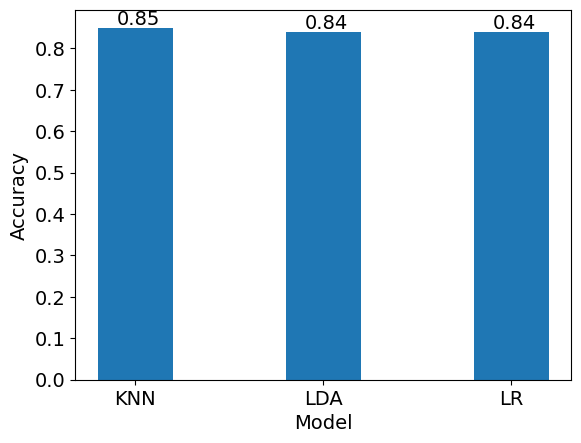

In [720]:
plot_models(models, accuracy_values)

In [735]:
cm_knn = get_cm(y_valid, predict_knn)

[[280  32]
 [ 34  69]]
              precision    recall  f1-score   support

          -1       0.89      0.90      0.89       312
           1       0.68      0.67      0.68       103

    accuracy                           0.84       415
   macro avg       0.79      0.78      0.79       415
weighted avg       0.84      0.84      0.84       415



In [817]:
cm_lda = get_cm(y_valid, predict_lda)

[[285  27]
 [ 38  65]]
              precision    recall  f1-score   support

          -1       0.88      0.91      0.90       312
           1       0.71      0.63      0.67       103

    accuracy                           0.84       415
   macro avg       0.79      0.77      0.78       415
weighted avg       0.84      0.84      0.84       415



In [818]:
cm_lr = get_cm(y_valid, predict_lr)

[[287  25]
 [ 39  64]]
              precision    recall  f1-score   support

          -1       0.88      0.92      0.90       312
           1       0.72      0.62      0.67       103

    accuracy                           0.85       415
   macro avg       0.80      0.77      0.78       415
weighted avg       0.84      0.85      0.84       415



### Balanced Error Rate (BER)

In [852]:
def get_ber(cm):
    a = cm[0][0]
    b = cm[0][1]
    c = cm[1][0]
    d = cm[1][1]
    ber = 0.5*(b/(a+b) + c/(c+d))
    return to_fix(ber, 3)

In [853]:
ber_knn = get_ber(cm_knn)    
ber_knn

0.216

In [854]:
ber_lda = get_ber(cm_lda)    
ber_lda

0.228

In [855]:
ber_lr = get_ber(cm_lr)
ber_lr

0.229

### Area Under Curve (AUC)

In [860]:
def get_auc(cm):
    ber = get_ber(cm)
    auc = 1 - ber
    return to_fix(auc,3)

In [861]:
auc_knn = get_auc(cm_knn)
auc_lda = get_auc(cm_lda)
auc_lr = get_auc(cm_lr)

In [862]:
auc_values = [auc_knn, auc_lda, auc_lr]
ber_values = [ber_knn, ber_lda, ber_lr]
models = ['KNN', 'LDA', 'LR']

data_ber_auc = {
    'Models': models, 
    'BER': ber_values,
    'AUC': auc_values} 
df_ber_auc = pd.DataFrame(data=data_ber_auc)

In [863]:
df_ber_auc

,Models,BER,AUC
0,KNN,0.216,0.784
1,LDA,0.228,0.772
2,LR,0.229,0.771


In [876]:
def get_auc_curve(clf, X_valid, y_valid, label_model):
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_valid, y_pred_proba)
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)
    auc = to_fix(auc,3)
    full_label = label_model + " auc="+str(auc)
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="TP = FP", alpha=0.8)
    plt.ylabel("TP rate")
    plt.xlabel("FP rate")
    plt.plot(fpr, tpr, label=full_label)
    plt.legend(loc=4)
    plt.show()

In [865]:
ber_knn

0.216

In [864]:
auc_knn

0.784

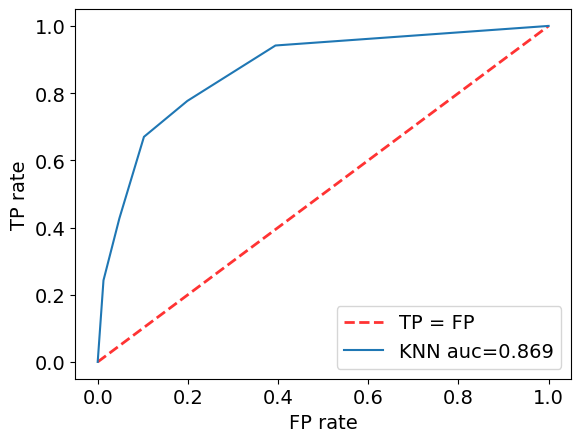

In [877]:
knn = get_knn_model(X_train, y_train, best_k)
get_auc_curve(knn, X_valid, y_valid, 'KNN')

In [826]:
ber_lda = get_ber(cm_lda)    
ber_lda

0.22773525018670648

In [828]:
get_auc(cm_lda)

0.7722647498132935

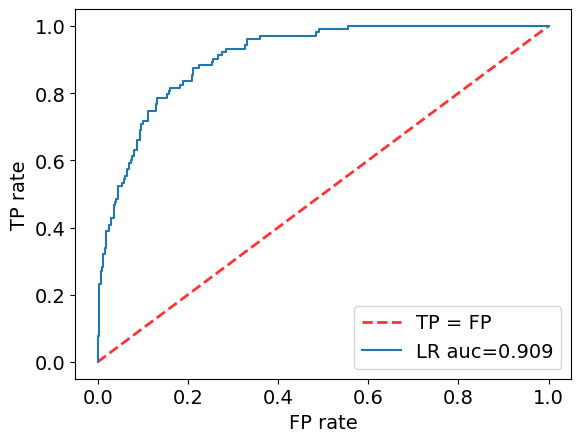

In [878]:
lr = get_lr_model(X_valid, y_valid)
get_auc_curve(lr, X_valid, y_valid, 'LR')

In [827]:
ber_lr = get_ber(cm_lr)    
ber_lr

0.22938449091361712

In [829]:
get_auc(cm_lr)

0.7706155090863829

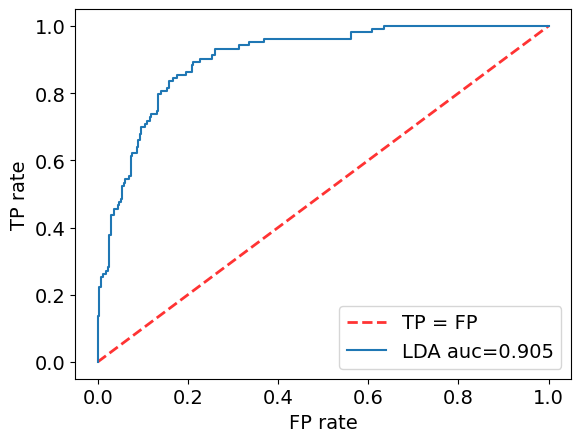

In [879]:
lda = get_lda_model(X_train, y_train)
get_auc_curve(lda, X_valid, y_valid, 'LDA')

### Compute confidence intervals and experimentally

In [886]:
n = len(X_valid)
alpha = 0.05
mean_hat = X_valid.mean() 
std_hat = X_valid.std(ddof=1)/np.sqrt(n) 

print(mean_hat)
print(std_hat)

-0.003372723407240033
0.048953226297736414


In [917]:
norm_rv = stats.norm()

z_crit = norm_rv.ppf(1 - alpha/2)
z_crit

1.959963984540054

In [983]:
mu_hat = X_valid.mean()
var_hat = X_valid.var(ddof=1)

print(mean_hat, var_hat)

-0.003372723407240033 0.9945136214573175


In [921]:
left = mu_hat - z_crit * np.sqrt(var_hat/n)
right = mu_hat + z_crit * np.sqrt(var_hat/n)

to_fix(left,3), to_fix(right,3)

(-0.099, 0.093)

In [926]:
stats.norm.interval(0.95, loc = mu_hat, scale = std_hat)

(-0.09931928387784245, 0.09257383706336239)

In [902]:
X_valid.max(), X_valid.min()

(45.52471856036015, -3.1407437935360587)

In [1025]:
def plot_norm_conf_int(alpha, mean_hat, std_hat, margin = 5):

    plt.figure(figsize=(10,5))
    # creating numeric sequences
    xs = np.linspace(mean_hat - margin, mean_hat + margin)
    
    # Probability density function (PDF) defines a probability distribution (the likelihood of an outcome) 
    # for a discrete random variable as opposed to a continuous random variable.
    pdf = stats.norm(mean_hat, std_hat).pdf(xs)
    
    plt.plot(xs, pdf)
    plt.ylabel('Frequency')
    plt.xlabel('x values')
    
    left, right = stats.norm.interval(1 - alpha, loc = mean_hat, scale = std_hat)
    
    for i in [left, right]:
        y_max = plt.ylim()[1]
        plt.axvline(i, color="blue", linestyle='dashed', lw=2)

        if i == left:
            xq = np.linspace(mean_hat - margin, left)
        else:
            xq = np.linspace(right, mean_hat + margin)
            
        text_margin = i * 0.1
        if i > 0:
            text_margin = -text_margin
        
        plt.text(i - text_margin, 0.8 * y_max, round(i, 3), color = 'blue')
        yq = stats.norm(mean_hat, std_hat).pdf(xq)
        plt.fill_between(xq, 0, yq, color = 'blue', alpha = 0.3)
        
    return to_fix(left,3), to_fix(right,3)

(-0.099, 0.093)

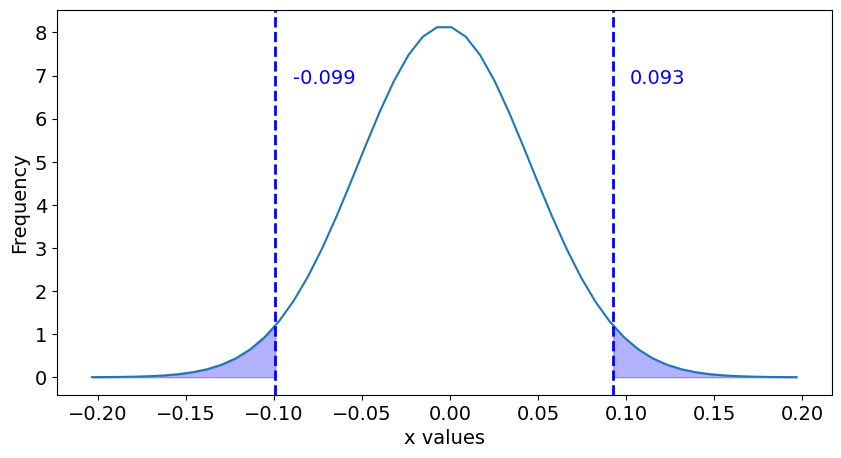

In [1026]:
data_plot = X_valid

n_tr = len(data_plot)
alpha = 0.05
mean_hat_tr = data_plot.mean() 
std_hat_tr = data_plot.std(ddof=1)/np.sqrt(n_tr)

plot_norm_conf_int(alpha, mean_hat_tr, std_hat_tr, 0.2)

(-0.099, 0.093)

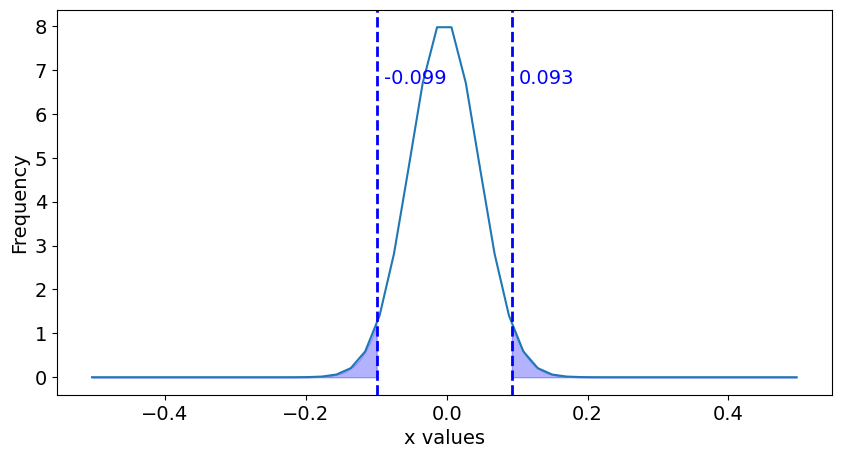

In [1027]:
plot_norm_conf_int(alpha, mean_hat, std_hat, 0.5)